# Category distance plot

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [76]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 58
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

58



# Data preparation

The points with the smallest distance are: tensor([ 0.0990, -0.4761]) from data_0 and tensor([ 0.2391, -0.1260]) from data_1


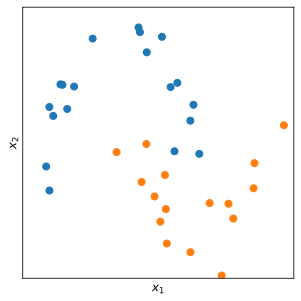

The points with the smallest distance are: tensor([ 0.0990, -0.4761]) from data_0 and tensor([ 0.2391, -0.1260]) from data_1


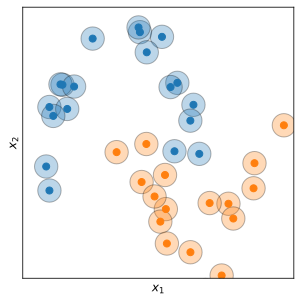

The points with the smallest distance are: tensor([ 0.0990, -0.4761]) from data_0 and tensor([ 0.2391, -0.1260]) from data_1


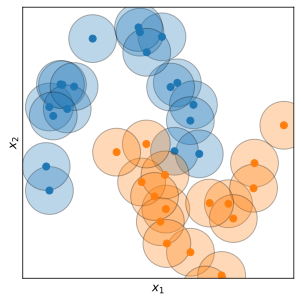

In [115]:
data_noise = 0.15
plotlim = [-2, 2]
subfolder = 'traj_moons'
batch_size = 45

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch, FancyArrow

from torch.utils import data as data
from torch.utils.data import DataLoader, TensorDataset


def pairwise_distances(x, y):
    # Compute squared distance matrix using broadcasting
    dists = torch.sum((x[:, None, :] - y[None, :, :]) ** 2, dim=2)
    return dists.sqrt()  # Take the square root to get the Euclidean distances


def create_dataloader(data_type, batch_size = 3000, noise = 0.15, factor = 0.15, random_state = 1, shuffle = True, plotlim = [-2, 2], label = 'scalar', ticks = True, markersize = 50, robust_plot = False, filename = 'moons', marker_factor = 15):
    label_types = ['scalar', 'vector']
    if label not in label_types:
        raise ValueError("Invalid label type. Expected one of: %s" % label_types)
    
    
    if data_type == 'circles':
        X, y = make_circles(batch_size, noise=noise, factor=factor, random_state=random_state, shuffle = shuffle)


        
    elif data_type == 'blobs':
        centers = [[-1, -1], [1, 1]]
        X, y = make_blobs(
    n_samples=batch_size, centers=centers, cluster_std=noise, random_state=random_state)
        
        
    elif data_type == 'moons':
        X, y = make_moons(batch_size, noise = noise, shuffle = shuffle , random_state = random_state)
    
    
    elif data_type == 'xor':
        X = torch.randint(low=0, high=2, size=(batch_size, 2), dtype=torch.float32)
        y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).float()
        # y = y.to(torch.int64)
        X += noise * torch.randn(X.shape)
        
        
    else: 
        print('datatype not supported')
        return None, None
    
    if label == 'vector':
        y = np.array([(2., 0.) if label == 1 else (-2., 0.) for label in y])

    g = torch.Generator()
    g.manual_seed(random_state)
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state, shuffle = shuffle)

    X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
    y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

    X_test = torch.Tensor(X_test) # transform to torch tensor for dataloader
    y_test = torch.Tensor(y_test) #transform to torch tensor for dataloader


    if label == 'scalar':
        X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
        y_train = y_train.type(torch.int64) #dtype of original picle.load data

        X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
        y_test = y_test.type(torch.int64) #dtype of original picle.load data
        
    else:
        X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
        y_train = y_train.type(torch.float32) #dtype of original picle.load data

        X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
        y_test = y_test.type(torch.float32) #dtype of original picle.load data


    train_data = TensorDataset(X_train,y_train) # create your datset
    test_data = TensorDataset(X_test, y_test)

    train = DataLoader(train_data, batch_size=64, shuffle=shuffle, generator=g)
    test = DataLoader(test_data, batch_size=256, shuffle=shuffle, generator = g) #128 before
    if label == 'scalar':
        data_0 = X_train[y_train == 0]
        data_1 = X_train[y_train == 1]
    else:
        data_0 = X_train[y_train[:,0] > 0]
        data_1 = X_train[y_train[:,0] < 0]
        

    
    marker_factor = marker_factor
    
    fig = plt.figure(figsize = (5,5), dpi = 100)
    
    if robust_plot:
        plt.scatter(data_1[:, 0], data_1[:, 1], c = 'C0', edgecolor='black', alpha = 0.3, s = marker_factor*markersize)
        plt.scatter(data_1[:, 0], data_1[:, 1], c = 'C0', alpha = 1, s = 0.5*markersize)
        plt.scatter(data_0[:, 0], data_0[:, 1], c = 'C1', edgecolor="black",  alpha = 0.3, s = marker_factor*markersize)
        plt.scatter(data_0[:, 0], data_0[:, 1], c = 'C1',  alpha = 1, s = 0.5*markersize)
    else:
        plt.scatter(data_1[:, 0], data_1[:, 1], c = 'C0', alpha = 1, s = 0.5*markersize)
        plt.scatter(data_0[:, 0], data_0[:, 1], c = 'C1',  alpha = 1, s = 0.5*markersize)
    plt.xlim([-2.,2])
    plt.ylim([-2,2])
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel(r'$x_1$', fontsize=12)
    plt.ylabel(r'$x_2$', fontsize=12)
    if ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    dist_matrix = pairwise_distances(data_0, data_1)

    # Step 2: Find the indices of the minimum value in the distance matrix
    min_dist_idx = torch.argmin(dist_matrix).item()
    min_dist_idx_0, min_dist_idx_1 = divmod(min_dist_idx, dist_matrix.size(1))

    # Extract the pair of points with the smallest distance
    point_from_data_0 = data_0[min_dist_idx_0]
    point_from_data_1 = data_1[min_dist_idx_1]
    
    print(f"The points with the smallest distance are: {point_from_data_0} from data_0 and {point_from_data_1} from data_1")    
    
    
    x_coords = [point_from_data_0[0].item(), point_from_data_1[0]]
    y_coords = [point_from_data_0[1].item(), point_from_data_1[1]]
    
    
    
   

    plt.savefig(filename + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
    plt.show()
    
    return train, test



dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, batch_size=batch_size, plotlim = plotlim, random_state = seed, label = 'vector', ticks = False, markersize = 100, filename = 'moons')

dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, batch_size=batch_size, plotlim = plotlim, random_state = seed, label = 'vector', ticks = False, markersize = 100, robust_plot= True, filename = 'moons_smalleps', marker_factor= 5.5)

dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, batch_size=batch_size, plotlim = plotlim, random_state = seed, label = 'vector', ticks = False, markersize = 100, robust_plot= True, filename = 'moons_largeeps', marker_factor= 23)

I want to visualize the separation boundary in the final linear layer.

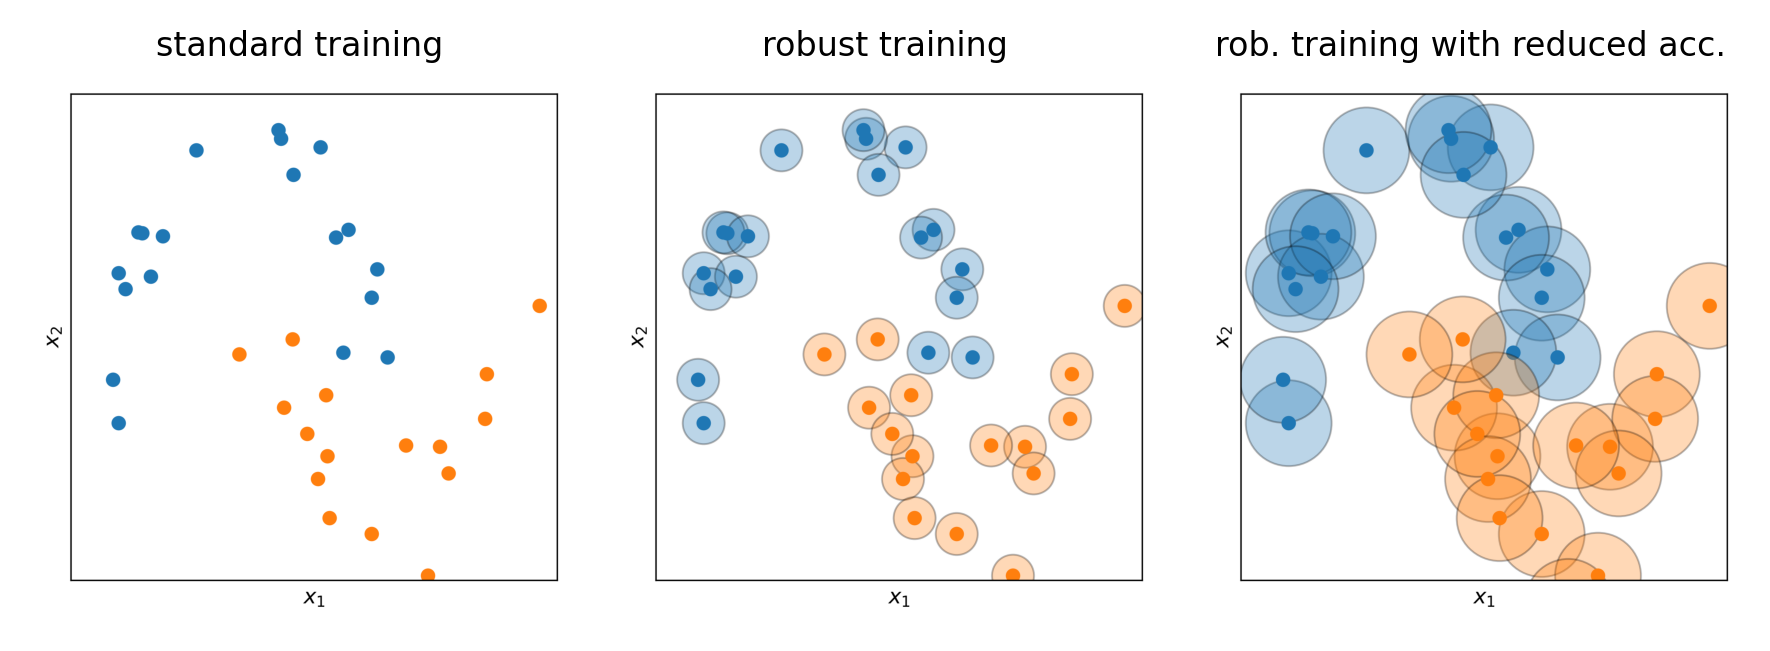

In [118]:
from IPython.display import Image
import imageio

def comparison_plot(filename1, title1, filename2, title2, filename3, title3, filename_output, figsize = None, show = False, dpi = 100, fontsize = 8):
    plt.figure(dpi = dpi, figsize=figsize)
    ax1 = plt.subplot(131)
    sub1 = imageio.imread(filename1)
    plt.imshow(sub1)
    plt.title(title1, fontsize = fontsize)
    plt.axis('off')

    plt.subplot(132, sharey = ax1)
    sub2 = imageio.imread(filename2)
    plt.imshow(sub2)
    plt.title(title2, fontsize = fontsize)
    plt.axis('off')
    
    plt.subplot(133, sharey = ax1)
    sub2 = imageio.imread(filename3)
    plt.imshow(sub2)
    plt.title(title3, fontsize = fontsize)
    plt.axis('off')
    
    plt.tight_layout()
    
    plt.savefig(filename_output, bbox_inches='tight', dpi=dpi, format='png', facecolor = 'white')
    if show: plt.show()
    else:
        plt.gca()
        plt.close()

comparison_plot("moons.png",  'standard training', 'moons_smalleps.png', 'robust training','moons_largeeps.png', 'rob. training with reduced acc.', "comp_learning.png", dpi = 300)
display(Image('comp_learning.png', width = 800))